<a href="https://colab.research.google.com/github/otanet/hannari_NLP_hands_on_2022/blob/main/%E6%96%87%E7%AB%A0%E5%88%86%E9%A1%9E_20220318_1902_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 文章分類とは
用意した文章を、事前に定義されたカテゴリーに、分類するタスクのこと。

以下の3つの分類手法がある。
- 2値分類
- 多クラス分類
- マルチクラス分類

## 2値分類とは
クラス数が2つの場合。

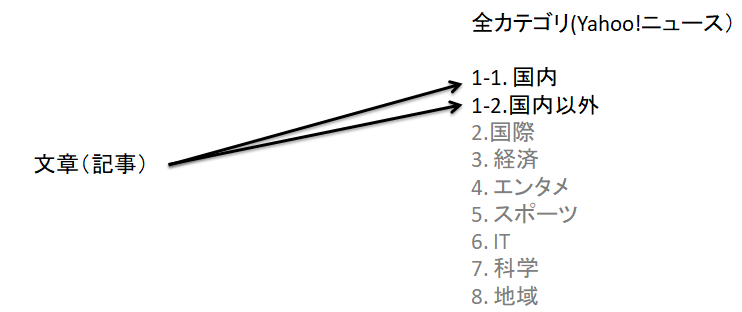


## 多クラス分類とは
クラス数が2つ以上の場合。

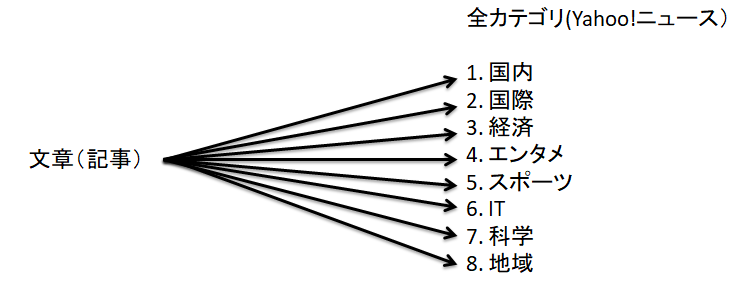



## マルチクラス分類とは
１つの文章に1つ以上のラベル/クラスが付けられるときのこと。

例）日産事件、検察側も控訴　ケリー被告大半無罪に不服(共同通信)

　元日産自動車会長カルロス・ゴーン被告（68）の役員報酬過少記載事件で、東京地検は16日、金融商品取引法違反（有価証券報告書の虚偽記載）の罪に問われた元代表取締役グレゴリー・ケリー被告（65）に大半を無罪とした東京地裁判決を不服として、控訴した。

https://news.yahoo.co.jp/pickup/6421060

→「国内」の問題でもあり、「経済」問題としても分けられる。またカルロス・ゴーンであれば、「国際」問題でもある。

→→このように、複数のクラスにまたがっている場合の分類をマルチクラス分類と言う。


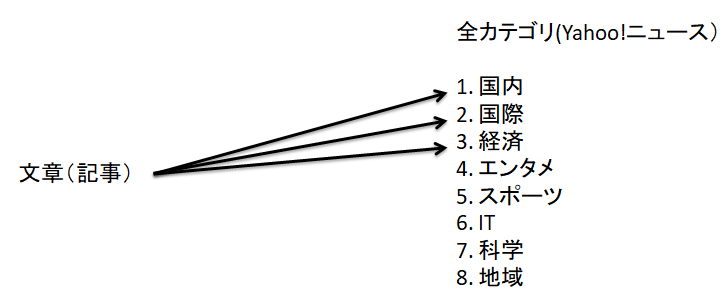

## カテゴリとは

Yahoo!ニュース
https://news.yahoo.co.jp/


全カテゴリ(Yahoo!ニュース)
8つのカテゴリ
https://news.yahoo.co.jp/topics

- 国内
- 国際
- 経済
- エンタメ
- スポーツ
- IT
- 科学
- 地域

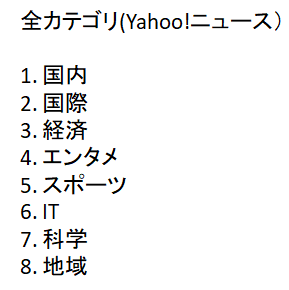

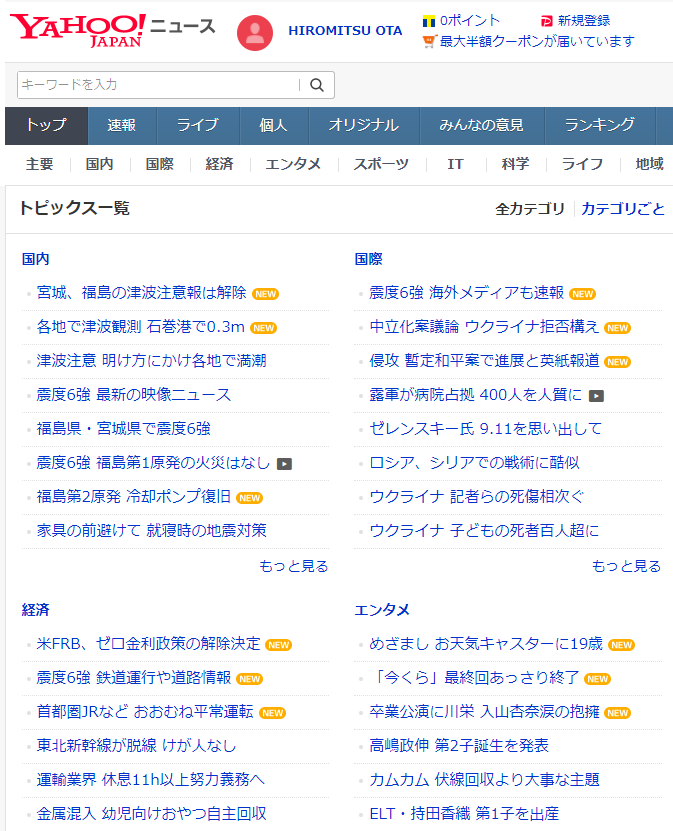

## コラム：ニュース記事のレコメンド
ニュース記事は、Yahoo!News内の記事だけでなく、異なる企業媒体(時事通信やCNNなど)で、おすすめの記事がレコメンドされます。

内部で統一されたカテゴリで用意しておく必要もあります。

以下のようなレコメンド表示に応用されています。

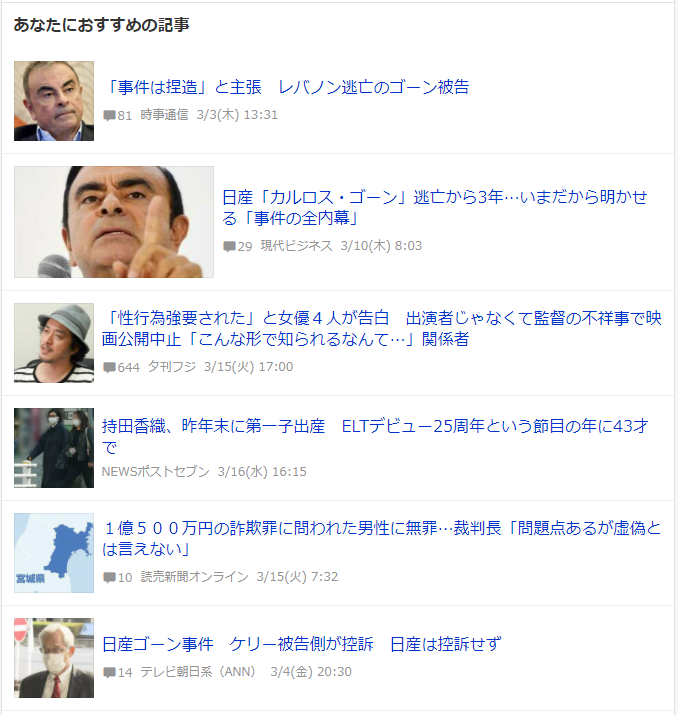



### カテゴリー：
### 商品カテゴリーやライブドア・ニュース・カテゴリーがある。

Google 商品カテゴリ :
https://support.google.com/merchants/answer/6324436#zippy=%2C%E3%83%95%E3%82%A1%E3%83%83%E3%82%B7%E3%83%A7%E3%83%B3%E9%96%A2%E9%80%A3%E5%95%86%E5%93%81

632,DIY用品,,,,,,
5181,旅行用かばん・バッグ,,,,,,
104,旅行用かばん・バッグ,ウェストポーチ・ヒップバッグ,,,,,
5608,旅行用かばん・バッグ,エコバッグ・買い物バッグ,,,,,

Google 商品カテゴリ [google_product_category]
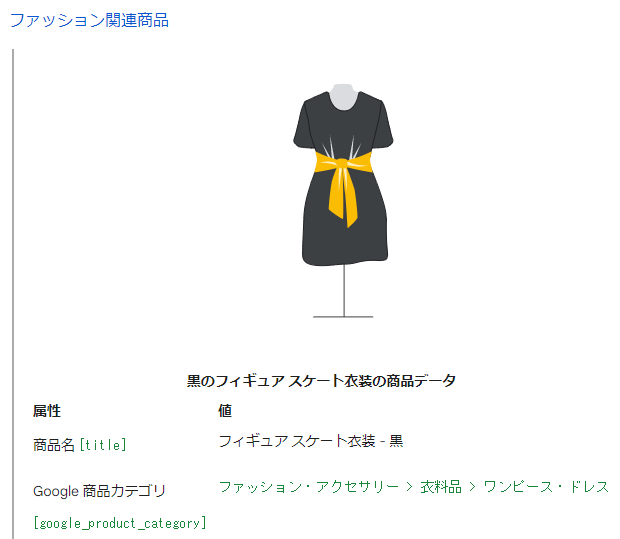


## 主な分類手法

- ナイーブベイズ分類器
- ロジスティック回帰
- サポートベクターマシン

- 単語埋め込み Word2Vec
- 文書埋め込み Doc2Vec
- CNNによるテキスト分類
- LSTMによるテキスト分類
- BERTなどの大規模な事前学習モデルを用いた分類

**→今回は「BERTなどの大規模な事前学習モデルを用いた分類」を取り上げます。**

※1 分類モデルの解釈可能性(LIME)やアクティブラーニング(Prodigy)やドメイン対応としての転移学習、さらに弱教師学習などもあるが、ここでは割愛します。

※2 既存のクラウドAPIの活用
Google Cloud Natural Languageでは、700以上のカテゴリに分割できるとされている。

次のような場合
複雑な分類やネジなどの部品の細かな分類などが該当する。
例) 健康/健康状態/痛みの管理

ビジネス利用では、700以上にまたがるカテゴリの分類でなければ、クラウドなどの既存のサービス利用より、内製化の方が、コストも効率的なケースが考えられます。


## それでは、「BERTなどの大規模な事前学習モデルを用いた分類」を試してみます。

- livedoor newsコーパスを用います。
- 日本語の事前学習モデル('cl-tohoku/bert-base-japanese-whole-word-masking')を用います。

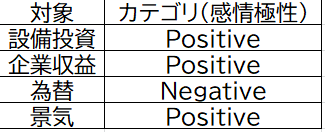


In [ ]:
# ディレクトリの作成
!mkdir hannari_nlp
%cd ./hannari_nlp

mkdir: cannot create directory ‘hannari_nlp’: File exists
/content/hannari_nlp


In [ ]:
# 必要なライブラリのインストール
!pip install transformers==4.5.0 fugashi==1.1.0 ipadic==1.0.0 pytorch-lightning==1.2.10
!pip install fugashi==1.1.0
!pip install ipadic==1.0.0
!pip install pytorch-lightning==1.2.10

In [ ]:
# # 必要なライブラリのインポート
import random
import glob
import json
from tqdm import tqdm

import torch
from torch.utils.data import DataLoader
from transformers import BertJapaneseTokenizer, BertModel
import pytorch_lightning as pl

# 日本語の事前学習モデル
MODEL_NAME = 'cl-tohoku/bert-base-japanese-whole-word-masking'

## 自然言語処理：可変長
paddingで入力サイズをそろえて、固定長のように処理する。
短い方の文章にpadを保管して、入力サイズをそろえておくと固定長のように扱える。

## cf. 画像処理：固定長



## マルチラベル分類とシングルラベル分類のイメージ
## Yahoo!ニュース（8カテゴリ）
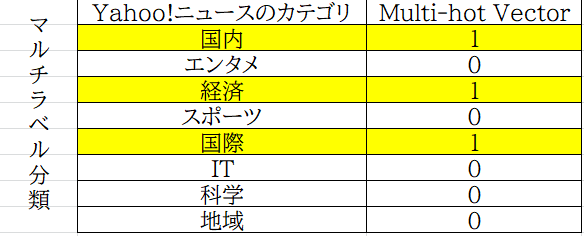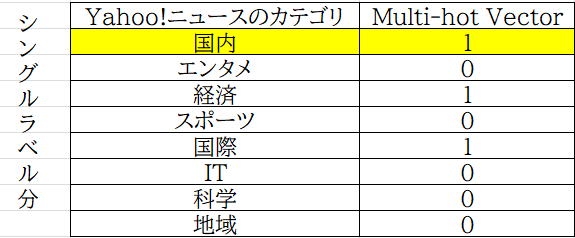

## BertForSequenceClassificationMultiLabelの処理のイメージ

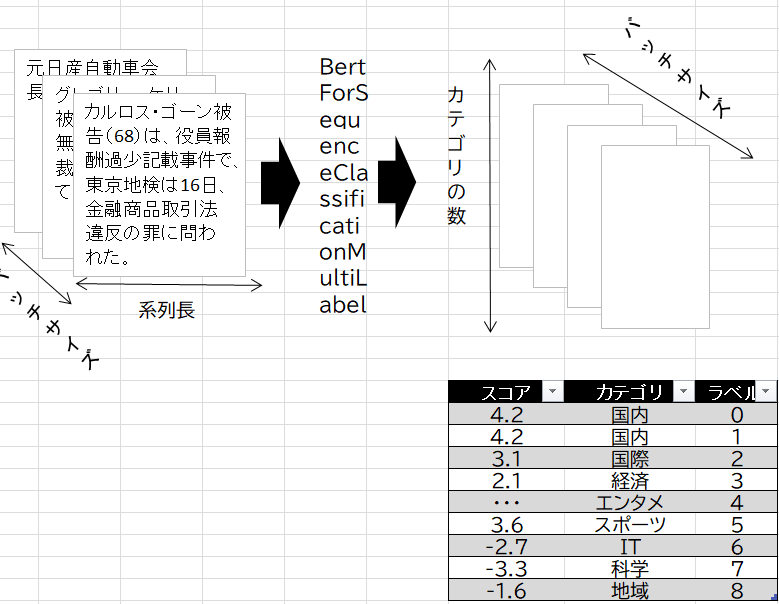

In [ ]:
#マルチラベル分類クラスの実装 
class BertForSequenceClassificationMultiLabel(torch.nn.Module):
    
    def __init__(self, model_name, num_labels):
        super().__init__()
        # BertModelのロード
        self.bert = BertModel.from_pretrained(model_name) 
        # 線形変換を初期化しておく
        self.linear = torch.nn.Linear(
            self.bert.config.hidden_size, num_labels
        ) 

    def forward(
        self, 
        input_ids=None, 
        attention_mask=None, 
        token_type_ids=None, 
        labels=None
    ):
        # データを入力しBERTの最終層の出力を得る。
        bert_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids)
        last_hidden_state = bert_output.last_hidden_state
        
        # [PAD]以外のトークンで隠れ状態の平均をとる
        averaged_hidden_state = \
            (last_hidden_state*attention_mask.unsqueeze(-1)).sum(1) \
            / attention_mask.sum(1, keepdim=True)
        
        # 線形変換
        scores = self.linear(averaged_hidden_state) 
        
        # 出力の形式を整える。
        output = {'logits': scores}

        # labelsが入力に含まれていたら、損失を計算し出力する。
        if labels is not None: 
            loss = torch.nn.BCEWithLogitsLoss()(scores, labels.float())
            output['loss'] = loss
            
        # 属性でアクセスできるようにする。
        output = type('bert_output', (object,), output) 

        return output

In [ ]:
# トークナイザーとモデルのロード
tokenizer = BertJapaneseTokenizer.from_pretrained(MODEL_NAME)
bert_scml = BertForSequenceClassificationMultiLabel(
    MODEL_NAME, num_labels=2
) 
bert_scml = bert_scml.cuda()

In [ ]:
# 与えられた文章のカテゴリ予測
text_list = [
    '元日産自動車会長カルロス・ゴーン被告の役員報酬過少記載事件があった。',
    '東京地検は16日、金融商品取引法違反の罪に問われた元代表取締役グレゴリー・ケリー被告に大半を無罪とした東京地裁判決を不服として、控訴した。'
]

labels_list = [
    [1, 1],
    [0, 1]
]

# データの符号化
encoding = tokenizer(
    text_list, 
    padding='longest',  
    return_tensors='pt'
)
encoding = { k: v.cuda() for k, v in encoding.items() }
labels = torch.tensor(labels_list).cuda()

# BERTへデータを入力し分類スコアを得る。
with torch.no_grad():
    output = bert_scml(**encoding)
scores = output.logits

# スコアが正ならば、そのカテゴリーを選択する。
labels_predicted = ( scores > 0 ).int()

# 精度の計算
num_correct = ( labels_predicted == labels ).all(-1).sum().item()
accuracy = num_correct/labels.size(0)

NameError: ignored

In [ ]:
# データの符号化処理
encoding = tokenizer(
    text_list, 
    padding='longest',  
    return_tensors='pt'
)
encoding['labels'] = torch.tensor(labels_list) # 入力にlabelsを含める。
encoding = { k: v.cuda() for k, v in encoding.items() }

output = bert_scml(**encoding)
loss = output.loss # 損失

## 上場企業の有価証券報告書を用いたポジ・ネガ・ニュートラル判定のデータセット(TIS)を用います。  
chABSA-dataset  
https://github.com/chakki-works/chABSA-datset/

昭和から平成にかけて、わが国の景気はゆるやかに回復した。企業収益が向上し、設備投資も積極的に行われた。銀行の発行する為替も改善された。

## 文章とカテゴリ、ラベルのイメージ(マルチラベルのポジネガ判定)

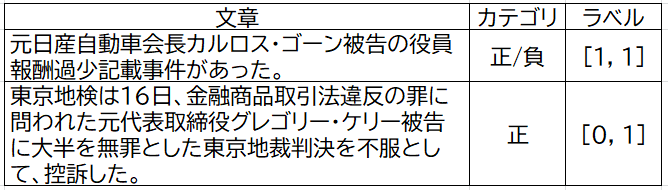

In [ ]:
# データのダウンロード(chABSA-dataset)とその解凍
!wget https://s3-ap-northeast-1.amazonaws.com/dev.tech-sketch.jp/chakki/public/chABSA-dataset.zip
!unzip chABSA-dataset.zip 

In [ ]:
# JSONファイルの読み込み
data = json.load(open('chABSA-dataset/e00030_ann.json'))
print( data['sentences'][0] )

In [ ]:
# カテゴリとラベルの設定・付与
category_id = {'negative':0, 'neutral':1 , 'positive':2}

dataset = []
for file in glob.glob('chABSA-dataset/*.json'):
    data = json.load(open(file))
    # 各データから文章（text）を抜き出し、ラベル（'labels'）を作成
    for sentence in data['sentences']:
        text = sentence['sentence'] 
        labels = [0,0,0]
        for opinion in sentence['opinions']:
            labels[category_id[opinion['polarity']]] = 1
        sample = {'text': text, 'labels': labels}
        dataset.append(sample)

In [ ]:
# 前処理後のデータセットの確認
print(dataset[0])

In [ ]:
# ファインチューニングとその評価に向けて
# データ分割(6:2:2)によるデータセットの生成
# トークナイザのローディング
tokenizer = BertJapaneseTokenizer.from_pretrained(MODEL_NAME)

# 各データの形式を整える
max_length = 128
dataset_for_loader = []
for sample in dataset:
    text = sample['text']
    labels = sample['labels']
    encoding = tokenizer(
        text,
        max_length=max_length,
        padding='max_length',
        truncation=True
    )
    encoding['labels'] = labels
    encoding = { k: torch.tensor(v) for k, v in encoding.items() }
    dataset_for_loader.append(encoding)

# データセットの分割
random.shuffle(dataset_for_loader) 
n = len(dataset_for_loader)
n_train = int(0.6*n)
n_val = int(0.2*n)
dataset_train = dataset_for_loader[:n_train] # 学習データ
dataset_val = dataset_for_loader[n_train:n_train+n_val] # 検証データ
dataset_test = dataset_for_loader[n_train+n_val:] # テストデータ

#　データセットからデータローダを作成
dataloader_train = DataLoader(
    dataset_train, batch_size=32, shuffle=True
) 
dataloader_val = DataLoader(dataset_val, batch_size=256)
dataloader_test = DataLoader(dataset_test, batch_size=256)

In [ ]:
# PyTorch Lightingによるファインチューニングと性能評価
class BertForSequenceClassificationMultiLabel_pl(pl.LightningModule):

    def __init__(self, model_name, num_labels, lr):
        super().__init__()
        self.save_hyperparameters() 
        self.bert_scml = BertForSequenceClassificationMultiLabel(
            model_name, num_labels=num_labels
        ) 

    def training_step(self, batch, batch_idx):
        output = self.bert_scml(**batch)
        loss = output.loss
        self.log('train_loss', loss)
        return loss
        
    def validation_step(self, batch, batch_idx):
        output = self.bert_scml(**batch)
        val_loss = output.loss
        self.log('val_loss', val_loss)

    def test_step(self, batch, batch_idx):
        labels = batch.pop('labels')
        output = self.bert_scml(**batch)
        scores = output.logits
        labels_predicted = ( scores > 0 ).int()
        num_correct = ( labels_predicted == labels ).all(-1).sum().item()
        accuracy = num_correct/scores.size(0)
        self.log('accuracy', accuracy)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

checkpoint = pl.callbacks.ModelCheckpoint(
    monitor='val_loss',
    mode='min',
    save_top_k=1,
    save_weights_only=True,
    dirpath='model/',
)

trainer = pl.Trainer(
    gpus=1, 
    max_epochs=5,
    callbacks = [checkpoint]
)

model = BertForSequenceClassificationMultiLabel_pl(
    MODEL_NAME, 
    num_labels=3, 
    lr=1e-5
)
trainer.fit(model, dataloader_train, dataloader_val)
test = trainer.test(test_dataloaders=dataloader_test)
print(f'Accuracy: {test[0]["accuracy"]:.2f}')

In [ ]:
# 与えられた文章の入力
text_list = [
    "昭和から平成にかけて、わが国の景気はゆるやかに回復した。",
    "企業収益が向上し、設備投資も積極的に行われた。",
    "銀行の発行する為替も改善された。"
]

# モデルのロード
best_model_path = checkpoint.best_model_path
model = BertForSequenceClassificationMultiLabel_pl.load_from_checkpoint(best_model_path)
bert_scml = model.bert_scml.cuda()

# データの符号化
encoding = tokenizer(
    text_list, 
    padding = 'longest',
    return_tensors='pt'
)
encoding = { k: v.cuda() for k, v in encoding.items() }

# BERTへデータを入力し分類スコアを得る。
with torch.no_grad():
    output = bert_scml(**encoding)
scores = output.logits
labels_predicted = ( scores > 0 ).int().cpu().numpy().tolist()

# 結果を表示
for text, label in zip(text_list, labels_predicted):
    print('--')
    print(f'入力：{text}')
    print(f'出力：{label}')

## まとめ
**1.文章分類とは**  
用意した文章を、事前に定義されたカテゴリーに、分類するタスクのこと。

以下の3つの分類手法がある。    
*2値分類*  
*多クラス分類*  
*マルチクラス分類*  


**2.値分類とは**  
クラス数が2つの場合。  


**3.多クラス分類とは**  
クラス数が2つ以上の場合。


**4.マルチクラス分類とは**  
１つの文章に1つ以上のラベル/クラスが付けられるときのこと。


**5.カテゴリとは**
Yahoo!ニュース 8つのカテゴリ 


**6.コラム：ニュース記事のレコメンド**
「あなたにおすすめの記事」
自社内で、統一されたカテゴリで用意しておく必要もあります。


**7.Googleの商品カテゴリー：**
商品カテゴリーやライブドア・ニュース・カテゴリ  

**8.主な分類手法**  
**1.ナイーブベイズ分類器**    
**2.ロジスティック回帰**  
**3.サポートベクターマシン**  
**4.単語埋め込み Word2Vec** 
**5.文書埋め込み Doc2Vec**  
**6.CNNによるテキスト分類**  
**7.LSTMによるテキスト分類**    
**8.BERTなどの大規模な事前学習モデルを用いた分類**  
  
  
**9.実装**  
→今回は「BERTなどの大規模な事前学習モデルを用いた分類」を取り上げました。  
  
**補足**  
自然言語処理：可変長    
cf. 画像処理：固定長  

### 参考文献一覧
参考文献一覧

displaCy Named Entity Visualizer · Explosion  
https://explosion.ai/demos/displacy-ent  


Explosion.aiのdisplaCy  
https://explosion.ai/demos/displacy ## Explosion.aiのdisplaCy  


日本語Winograd Schema Challengeの構築と分析  
言語処理学会 第21回年次大会 発表論文集 (2015年3月)  
https://www.anlp.jp/proceedings/annual_meeting/2015/pdf_dir/E3-1.pdf  


displaCy Dependency Visualizer · Explosion  
https://explosion.ai/demos/displacy  


※Pythonによる自然言語処理ハンズオン1 資料  2022/02/25  
https://www.slideshare.net/otanet/python-nlp-handson20220225v5  


共参照解析のための事象間関係知識の文脈化  
http://naoya-i.github.io/resources/nlp2014-paper.pdf  


Language modeling  
https://huggingface.co/docs/transformers/tasks/language_modeling  


Text classification  
https://huggingface.co/docs/transformers/tasks/sequence_classification  


Pipelines for inference  
https://huggingface.co/docs/transformers/pipeline_tutorial  

